# Group 1 - Challenge 1
Profile customers of the bank and predict who are likely to churn. As part  of the requirements, students have to define “What is a churn customer” by themselves

### **Mục lục**
1.   Introduction
2.   Data Wrangling
3.   Exploratory Data Analysis (EDA)
4.   Model Development
5.   Conclusion: Customer Churn

# 1. Introduction

### Tổng quan:
1. Bộ dữ liệu gồm các quan sát trong 3 mốc thời gian 31/12/2020, tháng 3/2021 và tháng 6/2021.
3. Cách thức định nghĩa Churn-Customer: Khách hàng có nhãn là "rời bỏ" là tệp khách hàng không có giao dịch (các biến liên quan đến transaction_amount) trong đồng thời cả tháng 3/2021 và tháng 6/2021. Sau đó, nhóm dựa vào bộ dữ liệu năm 2020 để xây dựng mô hình dự đoán biến Churn này.

In [1]:
# Import libraby
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, r2_score, PrecisionRecallDisplay, confusion_matrix, RocCurveDisplay, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from imblearn.over_sampling import SMOTE


import warnings
warnings.filterwarnings('ignore')

In [5]:
# Data
df = pd.read_csv('dataset.csv')

In [6]:
# Xoá khoảng trắng ở tên cột
df = df.rename(columns=lambda x: x.strip())

In [7]:
# Hiện thông tin dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 50 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   local_ref_1                   97266 non-null   object 
 1   vn_marital_status             96971 non-null   object 
 2   resid_province                93431 non-null   float64
 3   resid_district                93435 non-null   float64
 4   resid_wards                   93433 non-null   float64
 5   birth_incorp_date             99990 non-null   float64
 6   amount_week                   54800 non-null   float64
 7   max_amount_week               54800 non-null   float64
 8   min_amount_week               54800 non-null   float64
 9   distinct_payment_code_week    56850 non-null   float64
 10  count_payment_code_week       56850 non-null   float64
 11  distinct_trans_group_week     56850 non-null   float64
 12  distinct_ref_no_week          56850 non-null 

In [8]:
# Hiện tên cột
df.columns

Index(['local_ref_1', 'vn_marital_status', 'resid_province', 'resid_district',
       'resid_wards', 'birth_incorp_date', 'amount_week', 'max_amount_week',
       'min_amount_week', 'distinct_payment_code_week',
       'count_payment_code_week', 'distinct_trans_group_week',
       'distinct_ref_no_week', 'amount_month', 'max_amount_month',
       'min_amount_month', 'distinct_payment_code_month',
       'count_payment_code_month', 'distinct_trans_group_month',
       'distinct_ref_no_month', 'amount_3month', 'max_amount_3month',
       'min_amount_3month', 'distinct_payment_code_3month',
       'count_payment_code_3month', 'distinct_trans_group_3month',
       'distinct_ref_no_3month', 'most_act_mar2021_count', 'most_act_mar2021',
       'total_act_mar2021', 'total_amt_mar2021', 'most_act_juin2021_count',
       'most_act_juin2021', 'total_act_juin2021', 'total_amt_juin2021',
       'rd_id', 'savingValueMar2021_heoSo', 'savingValueJuin2021_heoSo',
       'totalLoginMar2021_heoSo', 'tot

# 2. Data wrangling

### Bước 1: Xoá những cột không sử dụng

Lý do loại cột liên quan đến heoSo và nhóm nợ: dữ liệu không liên quan nhiều đến việc khách hàng dời bỏ và xuất hiện nhiều giá trị null

In [9]:
# Xoá cột liên quan đến heoSo
df.drop(columns=['savingValueMar2021_heoSo', 'savingValueJuin2021_heoSo','totalLoginMar2021_heoSo',
                 'totalLoginJuin2021_heoSo','totalSavings2021_heoSo'], inplace=True)

In [10]:
# Xoá cột liên quan đến nhóm nợ
df.drop(columns=['balanceJuin2021', 'nominal_interestJuin2021','real_interestJuin2021',
                 'nhomno_xhtdJuin2021', 'categoryJuin2021','sub_productJuin2021',
                 'loaikyhanJuin2021', 'sectorJuin2021','product_codeJuin2021'], inplace=True)

Lý do loại cột liên quan đến vùng miền:
+ Có giá trị '1' xuất hiện nhiều dẫn đến có thể bị bias khi đưa vào mô hình
+ Việc khách hàng rời bỏ thường dựa vào hành vi thay vì nơi sinh sống

In [11]:
# Xoá cột liên quan đến vùng miền
df.drop(columns=['resid_province', 'resid_district','resid_wards'], inplace=True)

In [12]:
# Xoá id
df.drop(columns=['rd_id'], inplace=True)

In [13]:
df.columns

Index(['local_ref_1', 'vn_marital_status', 'birth_incorp_date', 'amount_week',
       'max_amount_week', 'min_amount_week', 'distinct_payment_code_week',
       'count_payment_code_week', 'distinct_trans_group_week',
       'distinct_ref_no_week', 'amount_month', 'max_amount_month',
       'min_amount_month', 'distinct_payment_code_month',
       'count_payment_code_month', 'distinct_trans_group_month',
       'distinct_ref_no_month', 'amount_3month', 'max_amount_3month',
       'min_amount_3month', 'distinct_payment_code_3month',
       'count_payment_code_3month', 'distinct_trans_group_3month',
       'distinct_ref_no_3month', 'most_act_mar2021_count', 'most_act_mar2021',
       'total_act_mar2021', 'total_amt_mar2021', 'most_act_juin2021_count',
       'most_act_juin2021', 'total_act_juin2021', 'total_amt_juin2021'],
      dtype='object')

### Bước 2: Chuẩn hoá dữ liệu

#### Giới tính
<p>Do số lượng nhóm Other ít nên chỉ chia thành 'Male' và 'Female', thay thế NaN bằng mode</p>

In [14]:
# Đổi tên cột
df.rename(columns = {'local_ref_1': 'gender'}, inplace = True)

In [15]:
# Thay thế NaN
df['gender'].fillna(df['gender'].mode()[0], inplace=True)
# Chuẩn hoá lại tên
df['gender'] = np.where(df['gender']=='MALE', 'Male', 'Female')

#### Tình trạng hôn nhân
<p>Do số lượng các nhóm như 'widow', 'separated' nhỏ nên chỉ chia thành 'Single' và 'In a relationship', thay thế NaN bằng mode

In [16]:
# Đổi tên cột
df.rename(columns = {'vn_marital_status': 'marital_status'}, inplace = True)

In [17]:
# Thay thế NaN
df['marital_status'].fillna(df['marital_status'].mode()[0], inplace=True)
# Chia dữ liệu thành 2 nhóm
df['marital_status'] = np.where(df['marital_status'].isin(['Single', 'Other', 'Partner', 'Seperated', 'Divorced',
       'Widow']), 'Single', 'In a relationship')

#### Năm sinh / Tuổi
<p>Chuyển năm sinh thành tuổi để chia group, loại bỏ các outlier</p>

In [18]:
# Tạo cột 'age'
df['age'] = 2024 - df.birth_incorp_date

In [19]:
# Thay thế NaN bằng mode
df['age'].fillna(df['age'].mode()[0], inplace=True)
# Thay thế Outlier bằng mode
df['age'] = np.where(df['age']<18, df['age'].mode()[0], df['age'])
df['age'] = np.where(df['age']>100, df['age'].mode()[0], df['age'])

In [20]:
# Xoá cột 'birth_incorp_date'
df.drop(columns=['birth_incorp_date'], inplace=True)

#### Giao dịch trong năm 2020 (amount, max, min)
<p>Giữ lại cột amount </p>

+ Giá trị > 0 thì dán nhãn <b>có giao dịch (1)</b></p>
+ Giá trị = 0 nhưng có min, max thì dãn nhán có <b>có giao dịch (1)</b></p>
+ Không có giá trị (null) thì coi như <b>không có giao dịch (0)</b></p>

<p>Loại các cột liên quan đến min, max để tránh đa cộng tuyến với cột amount</p>

In [21]:
# Tạo cột 'check_trans_amount_week' thay cho 'amount_week'
df['check_trans_amount_week'] = np.where((df['amount_week'].isnull()), 0, 1)

In [22]:
# Tạo cột 'check_trans_amount_month' thay cho 'amount_month'
df['check_trans_amount_month'] = np.where((df['amount_month'].isnull()), 0, 1)

In [23]:
# Tạo cột 'check_trans_amount_3month' thay cho 'amount_3month'
df['check_trans_amount_3month'] = np.where((df['amount_3month'].isnull()), 0, 1)

In [24]:
# Loại các cột không sử dụng
df.drop(columns=['amount_week', 'max_amount_week', 'min_amount_week',
                 'amount_month', 'max_amount_month', 'min_amount_month',
                 'amount_3month', 'max_amount_3month', 'min_amount_3month'
                ], inplace=True)

#### Giao dịch trong năm 2020 (distinct_payment_code)
<p>Tịnh tiến nhãn lên 1 đơn vị và đặt các nhãn null bằng 0

In [25]:
# Tịnh tiến nhãn 'distinct_payment_code_week' lên 1 đơn vị và đặt các nhãn null bằng 0
df['distinct_payment_code_week'] = df['distinct_payment_code_week'] + 1
df['distinct_payment_code_week'].fillna(0, inplace=True)

In [26]:
# Tịnh tiến nhãn 'distinct_payment_code_month' lên 1 đơn vị và đặt các nhãn null bằng 0
df['distinct_payment_code_month'] = df['distinct_payment_code_month'] + 1
df['distinct_payment_code_month'].fillna(0, inplace=True)

In [27]:
# Tịnh tiến nhãn 'distinct_payment_code_3month' lên 1 đơn vị (không có nhãn null)
df['distinct_payment_code_3month'] = df['distinct_payment_code_3month'] + 1

#### Số lượng giao dịch trong năm 2020 (count_payment_code)
<p>Xoá 2 cột 'count_payment_code_week' và 'count_payment_code_month', giữ lại cột 'count_payment_code_3month'</p>

In [28]:
# Xoá cột 'count_payment_code_week' và 'count_payment_code_month'
df.drop(columns=['count_payment_code_week', 'count_payment_code_month'], inplace=True)

In [29]:
# Thay thế outlier bằng 5th và 95th quantile
p_05 = df['count_payment_code_3month'].quantile(0.05) # 5th quantile
p_95 = df['count_payment_code_3month'].quantile(0.95) # 95th quantile
df['count_payment_code_3month'].clip(p_05, p_95, inplace=True)

#### Giao dịch trong năm 2020 (distinct_trans_group và distinct_ref_no)

In [30]:
# Đặt các nhãn null bằng 0, 'distinct_trans_group_3month' không có null
df['distinct_trans_group_week'].fillna(0, inplace=True)
df['distinct_trans_group_month'].fillna(0, inplace=True)

In [31]:
# Xoá cột 'distinct_ref_no'
df.drop(columns=['distinct_ref_no_week', 'distinct_ref_no_month', 'distinct_ref_no_3month'], inplace=True)

In [32]:
df.columns

Index(['gender', 'marital_status', 'distinct_payment_code_week',
       'distinct_trans_group_week', 'distinct_payment_code_month',
       'distinct_trans_group_month', 'distinct_payment_code_3month',
       'count_payment_code_3month', 'distinct_trans_group_3month',
       'most_act_mar2021_count', 'most_act_mar2021', 'total_act_mar2021',
       'total_amt_mar2021', 'most_act_juin2021_count', 'most_act_juin2021',
       'total_act_juin2021', 'total_amt_juin2021', 'age',
       'check_trans_amount_week', 'check_trans_amount_month',
       'check_trans_amount_3month'],
      dtype='object')

### Bước 3: Tạo cột Churn
<p> Khách hàng được coi là CHURN khi cả 8 giá trị trong cả tháng 3 và 6/2021 cùng Null)</p>

In [33]:
# Tạo cột 'churn' từ điều kiện bên trên
# Điều kiện trong tháng 3 cả 4 giá trị đều null
check_null_mar2021 = (df['most_act_mar2021_count'].isnull()) & (df['most_act_mar2021'].isnull()) & (df['total_act_mar2021'].isnull()) &  (df['total_amt_mar2021'].isnull())
# Điều kiện trong tháng 6 cả 4 giá trị đều null
check_null_juin2021 = (df['most_act_juin2021_count'].isnull()) & (df['most_act_juin2021'].isnull()) & (df['total_act_juin2021'].isnull()) &  (df['total_amt_juin2021'].isnull())

df['churn'] = np.where(np.logical_and(check_null_mar2021, check_null_juin2021),1,0)

In [34]:
# Xoá 8 cột vừa sử dụng
df.drop(columns=['most_act_mar2021_count', 'most_act_mar2021', 'total_act_mar2021', 'total_amt_mar2021',
                 'most_act_juin2021_count', 'most_act_juin2021','total_act_juin2021', 'total_amt_juin2021'],
        inplace=True)

In [35]:
# Viết dữ liệu ra file csv
df.to_csv('Cleaned Data FDC105.csv')

# 3. EDA

In [2]:
df = pd.read_csv('Cleaned Data FDC105.csv')
df.head()

,Unnamed: 0,gender,marital_status,distinct_payment_code_week,distinct_trans_group_week,distinct_payment_code_month,distinct_trans_group_month,distinct_payment_code_3month,count_payment_code_3month,distinct_trans_group_3month,age,check_trans_amount_week,check_trans_amount_month,check_trans_amount_3month,churn
0,0,Male,In a relationship,1.0,1.0,1.0,2.0,1,0.0,2,32.0,0,1,1,0
1,1,Male,Single,0.0,0.0,1.0,1.0,1,0.0,2,38.0,0,1,1,0
2,2,Male,In a relationship,0.0,0.0,1.0,1.0,3,3.0,2,44.0,0,1,1,0
3,3,Male,Single,0.0,0.0,0.0,0.0,1,0.0,1,23.0,0,0,0,1
4,4,Male,In a relationship,1.0,1.0,2.0,3.0,2,11.0,3,35.0,1,1,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    100000 non-null  int64  
 1   gender                        100000 non-null  object 
 2   marital_status                100000 non-null  object 
 3   distinct_payment_code_week    100000 non-null  float64
 4   distinct_trans_group_week     100000 non-null  float64
 5   distinct_payment_code_month   100000 non-null  float64
 6   distinct_trans_group_month    100000 non-null  float64
 7   distinct_payment_code_3month  100000 non-null  int64  
 8   count_payment_code_3month     100000 non-null  float64
 9   distinct_trans_group_3month   100000 non-null  int64  
 10  age                           100000 non-null  float64
 11  check_trans_amount_week       100000 non-null  int64  
 12  check_trans_amount_month      100000 non-null

### 3.1. Gender (Giới tính):

<p>Số lượng nam giới chiếm 2/3 tổng số người khảo sát</p>
<p>Phần trăm khách hàng rời bỏ khá cân bằng với cả 2 giới tính, xấp xỉ 21%</p>

[Text(0, 0, '66914'), Text(0, 0, '33086')]

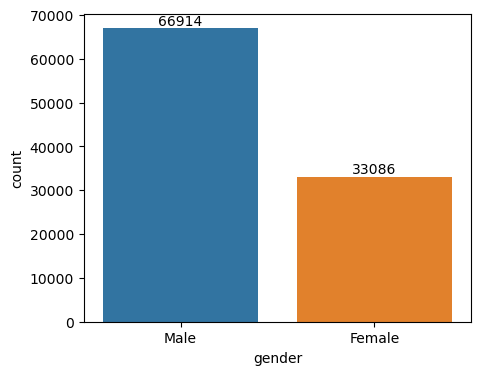

In [4]:
plt.figure(figsize=(5, 4))

ax = sns.countplot(data = df, x="gender")
ax.bar_label(ax.containers[0])

Percentage churn male customer: 21.769734285799682
Percentage churn male customer: 20.226077495012994


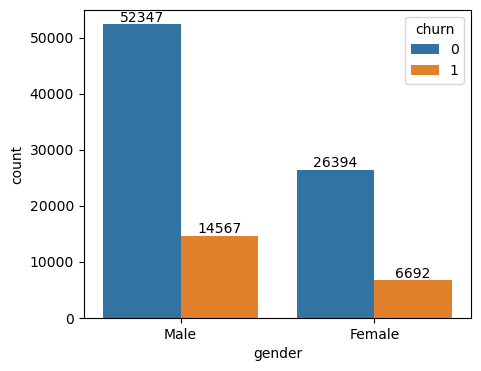

In [5]:
plt.figure(figsize=(5, 4))

ax = sns.countplot(data= df, x="gender", hue="churn")
for container in ax.containers:
    ax.bar_label(container)
male_churn_percent = 14567/66914
female_churn_percent = 6692/33086
print(f'Percentage churn male customer: {male_churn_percent*100}')
print(f'Percentage churn male customer: {female_churn_percent*100}')

### 3.2. Marital_status (Tình trạng hôn nhân)
<p>Khách hàng độc thân chiếm 57%, khách hàng trong mối quan hệ chiếm 43%</p>
<p>Khách hàng độc thân có xu hướng rời bỏ cao hơn</p>

[Text(0, 0, '42126'), Text(0, 0, '57874')]

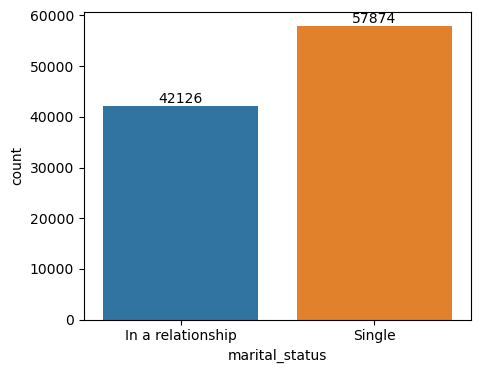

In [6]:
plt.figure(figsize=(5, 4))

ax = sns.countplot(data=df, x="marital_status")
ax.bar_label(ax.containers[0])

Percentage churn single customer: 28.05059266682794
Percentage churn in a relationship customer: 11.92850021364478


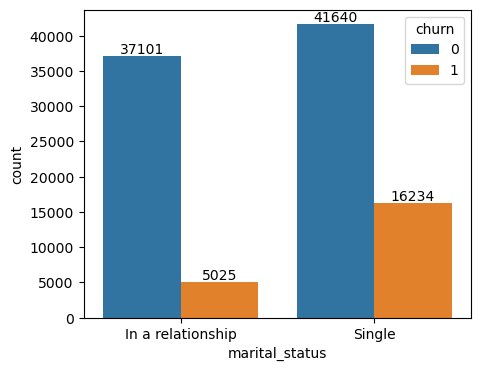

In [7]:
plt.figure(figsize=(5, 4))

ax = sns.countplot(data=df, x="marital_status", hue="churn")
for container in ax.containers:
    ax.bar_label(container)
single_churn_percent = 16234/57874
rela_churn_percent = 5025/42126
print(f'Percentage churn single customer: {single_churn_percent*100}')
print(f'Percentage churn in a relationship customer: {rela_churn_percent*100}')

### 3.3. Age (Độ tuổi)
<p>Độ tuổi trung bình khách hàng vào khoảng 35 tuổi</p>
<p>Tệp khách hàng churn có xu hướng trẻ hơn</p>

In [8]:
df['age'].describe()

count    100000.000000
mean         35.511730
std           8.972534
min          18.000000
25%          29.000000
50%          34.000000
75%          41.000000
max          94.000000
Name: age, dtype: float64

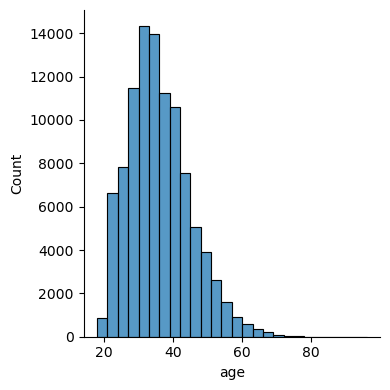

In [9]:
sns.displot(df, x="age", binwidth=3, height=4, aspect=1)

<AxesSubplot:xlabel='age'>

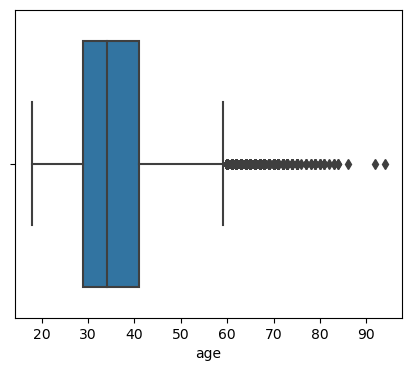

In [10]:
plt.figure(figsize=(5, 4))

sns.boxplot(data=df, x='age')

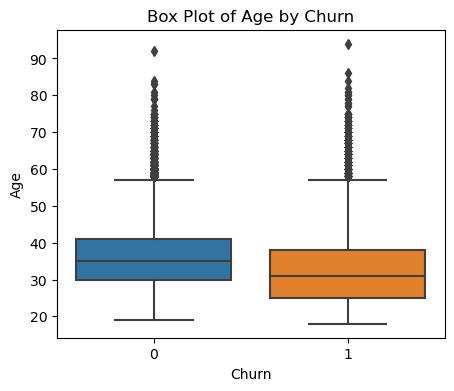

In [11]:
plt.figure(figsize=(5, 4))

sns.boxplot(data=df, x='churn', y='age')
plt.xlabel('Churn')
plt.ylabel('Age')
plt.title('Box Plot of Age by Churn')
plt.show()

### 3.4 Distinct_payment_code (Loại dịch vụ khách hàng sử dụng)

In [12]:
df.columns

Index(['Unnamed: 0', 'gender', 'marital_status', 'distinct_payment_code_week',
       'distinct_trans_group_week', 'distinct_payment_code_month',
       'distinct_trans_group_month', 'distinct_payment_code_3month',
       'count_payment_code_3month', 'distinct_trans_group_3month', 'age',
       'check_trans_amount_week', 'check_trans_amount_month',
       'check_trans_amount_3month', 'churn'],
      dtype='object')

In [13]:
# Chuyển các cột có dạng float sang int để đồng nhất với các cột còn lại
df['distinct_payment_code_week'] = df['distinct_payment_code_week'].astype(int)
df['distinct_trans_group_week'] = df['distinct_trans_group_week'].astype(int)
df['distinct_payment_code_month'] = df['distinct_payment_code_month'].astype(int)
df['distinct_trans_group_month'] = df['distinct_trans_group_month'].astype(int)
df['count_payment_code_3month'] = df['count_payment_code_3month'].astype(int)
df['age'] = df['age'].astype(int)

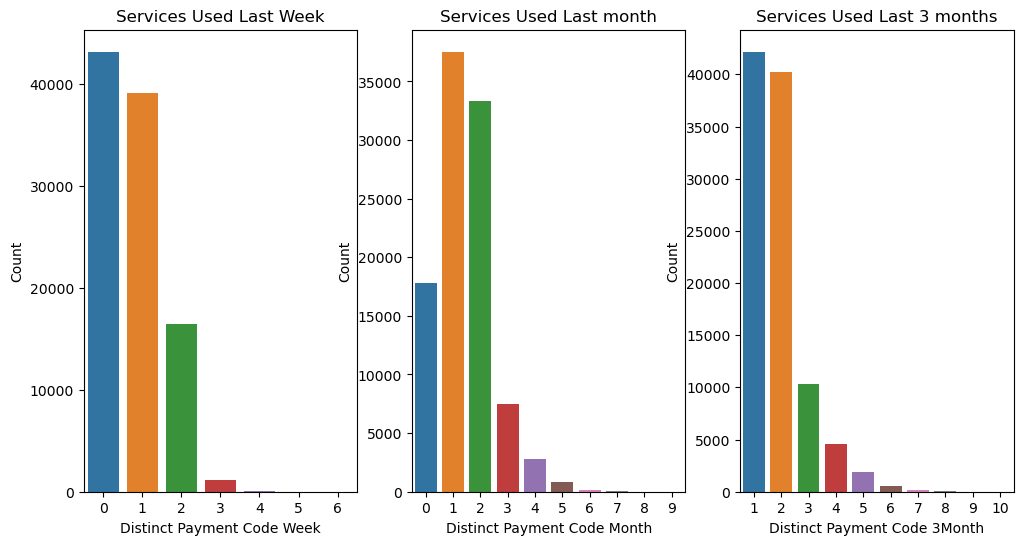

In [14]:
# Count plot cho nhóm cột Loại dịch vụ distinct_payment_code
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.countplot(data=df, x='distinct_payment_code_week')
plt.title('Services Used Last Week')
plt.xlabel('Distinct Payment Code Week')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.countplot(data=df, x='distinct_payment_code_month')
plt.title('Services Used Last month')
plt.xlabel('Distinct Payment Code Month')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.countplot(data=df, x='distinct_payment_code_3month')
plt.title('Services Used Last 3 months')
plt.xlabel('Distinct Payment Code 3Month')
plt.ylabel('Count')

plt.show()

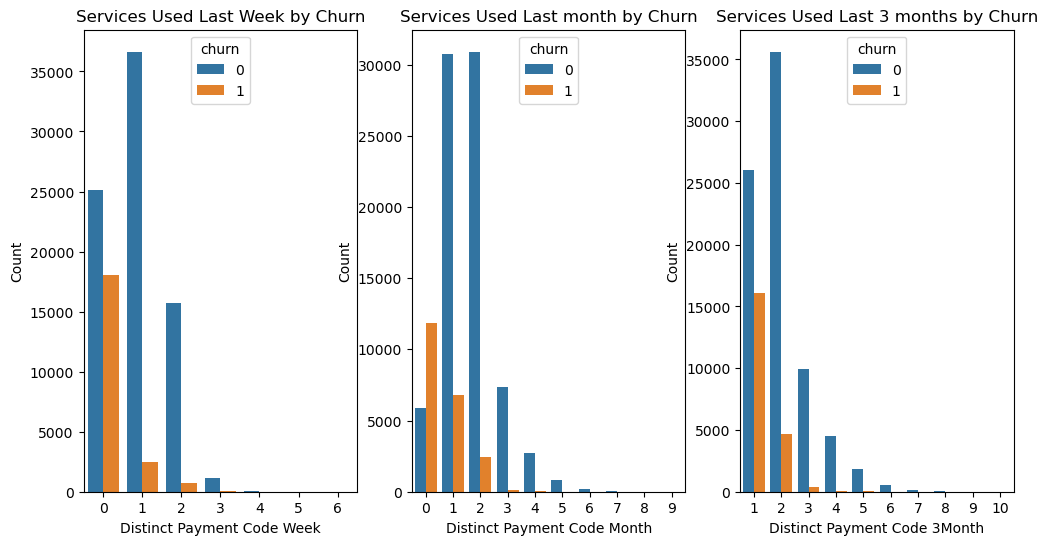

In [15]:
# Count plot for distinct_payment_code
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.countplot(data=df, x='distinct_payment_code_week', hue='churn')
plt.title('Services Used Last Week by Churn')
plt.xlabel('Distinct Payment Code Week')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.countplot(data=df, x='distinct_payment_code_month', hue='churn')
plt.title('Services Used Last month by Churn')
plt.xlabel('Distinct Payment Code Month')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.countplot(data=df, x='distinct_payment_code_3month', hue='churn')
plt.title('Services Used Last 3 months by Churn')
plt.xlabel('Distinct Payment Code 3Month')
plt.ylabel('Count')

plt.show()

Từ 3 biểu đồ trên, nhóm thấy những người không sử dụng loại dịch vụ nào ('distinct_payment_code' = 0) có xu hướng churn nhiều hơn

<Figure size 200x100 with 0 Axes>

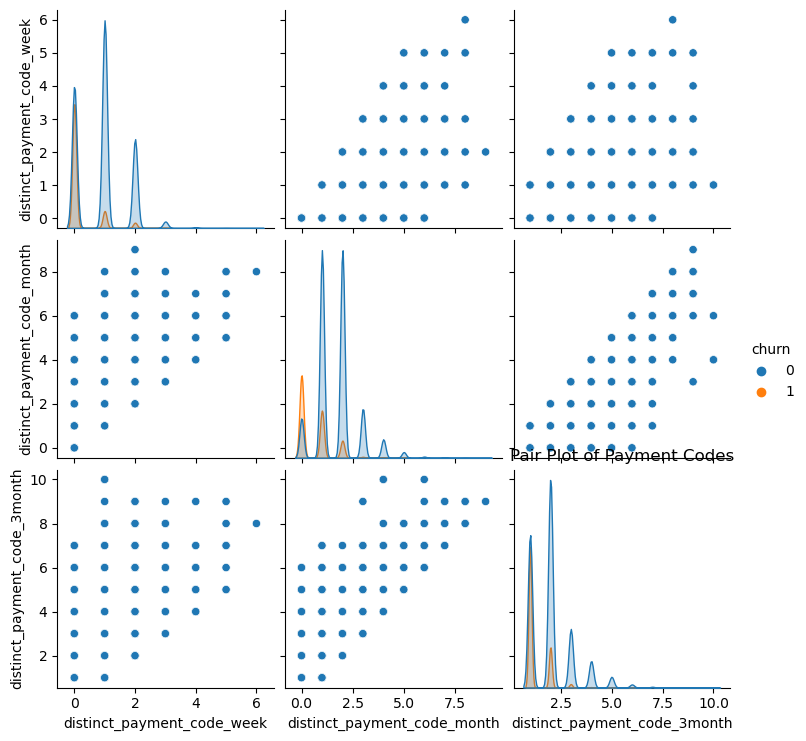

In [16]:
plt.figure(figsize=(2,1))

sns.pairplot(df, vars=['distinct_payment_code_week', 'distinct_payment_code_month', 'distinct_payment_code_3month'], hue='churn')
plt.title('Pair Plot of Payment Codes')
plt.show()

Phân phối các loại dịch vụ khách hàng sử dụng theo tuần và theo tháng
- Đa số khách hàng không sử dụng loại dịch vụ nào hoặc sử dụng loại dịch vụ 1,2 trong tuần và trong tháng.
- Số lượng khách hàng sử dụng loại dịch vụ từ 3 trở lên giảm dần.

Phân phối các loại dịch vụ theo 3 tháng:
- Xu hướng tương tự như phân phối của các loại dịch vụ theo tháng nhưng có phạm vi sử dụng rộng hơn, không có khách hàng nào không loại sử dụng dịch vụ gì (không có null)
- Loại dịch vụ khách hàng sử dụng trong 3 tháng có thể mang giá trị đến 10.

Mối quan hệ với churn:
- Các khách hàng có churn (màu cam) thường có xu hướng không sử dụng loại dịch vụ nào hoặc sử dụng loại dịch vụ 1,2,3 trong tuần, tháng và 3 tháng.
- Điều này có thể chỉ ra rằng khách hàng sử dụng dịch vụ thấp hơn có khả năng churn cao hơn.

=> Do đó, nhóm cho rằng, nhóm cột này có thể sử dụng làm biến giải thích cho hiện tượng churn của khách hàng.

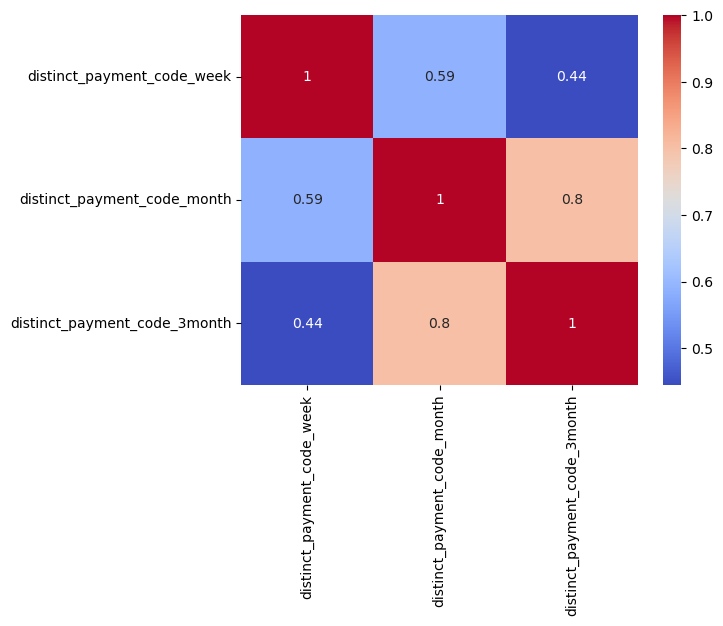

In [17]:
# Tạo ma trận tương quan
corr_matrix = df[['distinct_payment_code_week', 'distinct_payment_code_month', 'distinct_payment_code_3month']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Từ ma trận tương quan dạng heatmap, nhóm thấy rằng cột 'distinct_payment_code_month' có độ tương quan khá cao với 2 cột 1 tuần và 3 tháng trước đó. Do đó, nhóm đề xuất loại bỏ cột 'distinct_payment_code_month' để tránh hiện tượng đa cộng tuyến.

In [18]:
df.drop(columns=['distinct_payment_code_month'], inplace=True)

### 3.5. Count_payment_code (Số lượng dịch vụ khách hàng sử dụng)

In [19]:
# Check các loại giao dịch (disticnt code)
unique_values = df['distinct_payment_code_3month'].unique()
print(unique_values)

[ 1  3  2  4  5  6  7  9  8 10]


Có 10 loại giao dịch (code for type) 

Text(0, 0.5, 'Count')

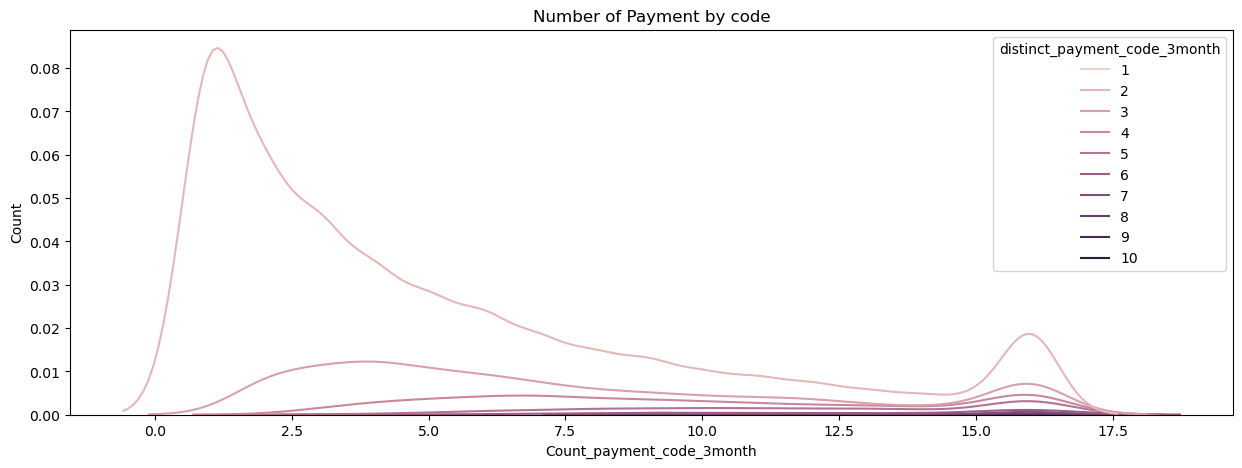

In [20]:
plt.figure(figsize=(15, 5))
sns.kdeplot(data=df, x="count_payment_code_3month", hue="distinct_payment_code_3month")
plt.title('Number of Payment by code')
plt.xlabel('Count_payment_code_3month')
plt.ylabel('Count')

### Nhận xét:
1. Với các quan sát trong 3 tháng, thì giao dịch mã code 01 có số lượng sử dụng nổi bật hơn hẳn so với các mã code còn lại
2. Đa số khách hàng có sử dung dịch vụ với tần suất vừa (Dưới 7 dịch vụ/ 3 month).
3. Tần suất càng lớn thì số lượng thực hiện dịch vụ giảm dần, tuy nhiên, mốc 15 dịch vụ có xu hướng tăng mạnh trở lên trong hành vi của khách hàng.

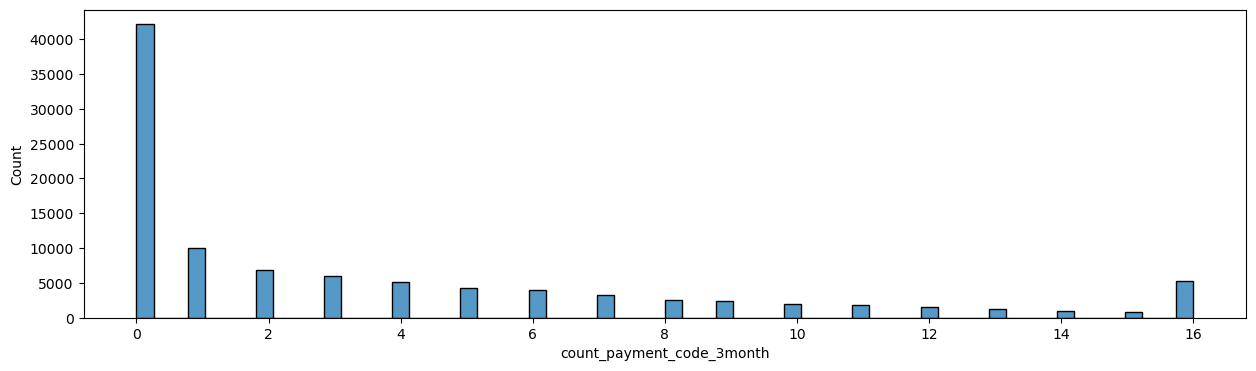

In [21]:
fig,ax = plt.subplots(figsize=(15,4))
df['count_payment_code_3month'] = df['count_payment_code_3month'].astype(float)
ax = sns.histplot(df, x='count_payment_code_3month')

Số lượng khách hàng không thực hiện dịch vụ nào chiếm phần lớn

Text(0, 0.5, 'Count')

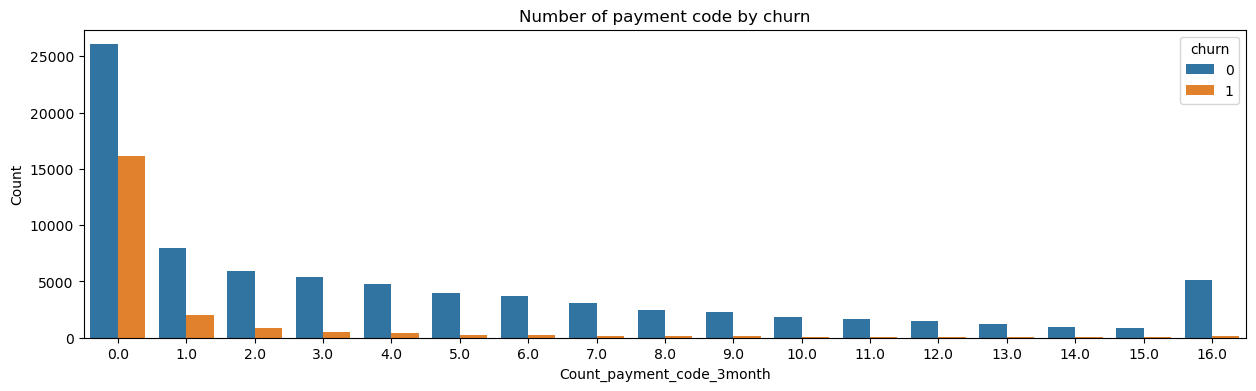

In [22]:
fig,ax = plt.subplots(figsize=(15,4))

ax = sns.countplot(x='count_payment_code_3month', hue='churn', data=df)
plt.title('Number of payment code by churn')
plt.xlabel('Count_payment_code_3month')
plt.ylabel('Count')

### Nhận xét:
* Cụ thể hơn của cột "check_trans_amount", đây là biểu đồ phân hóa cụ thể biến churn hơn với biến Tần suất sử dụng dịch vụ (count_payment_code_3month)
* Trong vòng 3 tháng quan sát của năm 2020, số lượng khách hàng không sử dụng dịch vụ nào có tệp không rời bỏ và rời bỏ cao hơn hẳn so với nhóm có sử dụng dịch vụ. Điều này cũng cho thấy khi khách hàng sử dụng các dịch vụ với tần suất lớn sẽ có xu hướng ít rời bỏ hơn tệp khách hàng sử dụng dịch vụ với tần suất thấp hơn, cụ thể như tần suất đạt 16.
* Số lượng khách hàng không rời bỏ luôn lớn hơn hẳn so với số lượng khách hàng rời bỏ, và hai dữ liệu này có xu hướng giảm dần khi tần suất tăng lên

### 3.6 Distinct_trans_group (Nhóm giao dịch khách hàng sử dụng)

In [23]:
df['distinct_trans_group_week'].describe()

count    100000.000000
mean          0.847020
std           0.910333
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: distinct_trans_group_week, dtype: float64

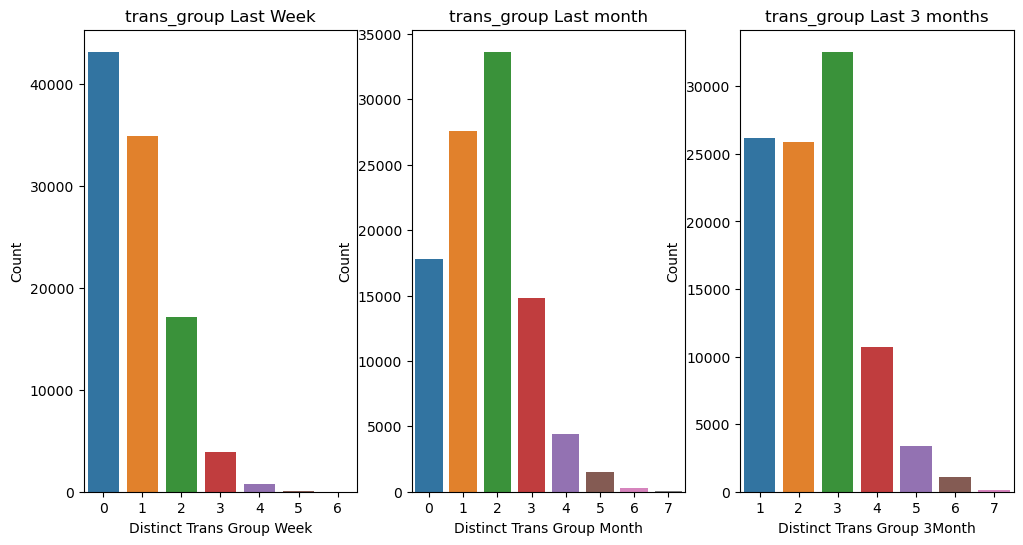

In [24]:
# Count plot cho các cột Nhóm giao dịch khách hàng sử dụng
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.countplot(data=df, x='distinct_trans_group_week')
plt.title('trans_group Last Week')
plt.xlabel('Distinct Trans Group Week')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.countplot(data=df, x='distinct_trans_group_month')
plt.title('trans_group Last month')
plt.xlabel('Distinct Trans Group Month')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.countplot(data=df, x='distinct_trans_group_3month')
plt.title('trans_group Last 3 months')
plt.xlabel('Distinct Trans Group 3Month')
plt.ylabel('Count')

plt.show()

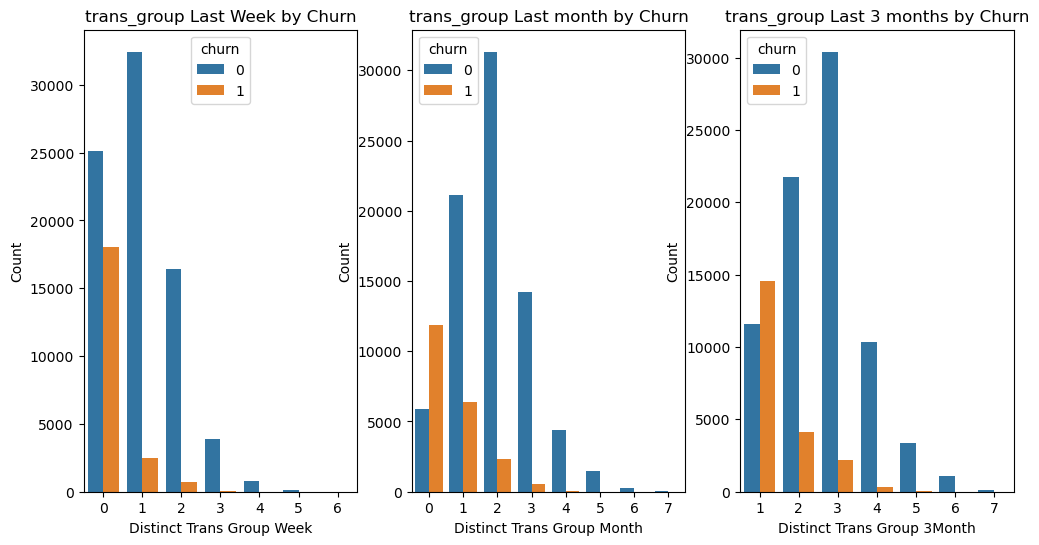

In [25]:
# Count plot cho các cột Nhóm giao dịch khách hàng sử dụng
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.countplot(data=df, x='distinct_trans_group_week', hue='churn')
plt.title('trans_group Last Week by Churn')
plt.xlabel('Distinct Trans Group Week')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.countplot(data=df, x='distinct_trans_group_month', hue='churn')
plt.title('trans_group Last month by Churn')
plt.xlabel('Distinct Trans Group Month')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.countplot(data=df, x='distinct_trans_group_3month', hue='churn')
plt.title('trans_group Last 3 months by Churn')
plt.xlabel('Distinct Trans Group 3Month')
plt.ylabel('Count')

plt.show()

Về tổng thể, Hầu hết các khách hàng tập trung vào các Nhóm giao dịch có giá trị thấp hơn (0-3) trong tất cả các khoảng thời gian.

Về phân bố cụ thể theo từng biến:

- Tuần trước: Phân bố nhiều nhất ở các giá trị 0 và 1. Điều này cho thấy nhiều khách hàng không sử dụng hoặc chỉ sử dụng nhóm giao dịch 1.
- Tháng trước: Phân bố tập trung ở các giá trị 0, 1, 2.
- 3 tháng trước: Phân bố mở rộng hơn so với tuần và tháng trước, với nhiều khách hàng sử dụng nhóm giao dịch thứ 3.

Tuy nhiên, tỷ lệ churn ở các khách hàng không sử dụng nhóm giao dịch nào (giá trị 0) ở dữ liệu tuần và tháng khá cao, còn các khách hàng sử dụng nhóm giao dịch 1 lại có tỷ lệ churn cao ở dữ liệu 3 tháng. Nhóm đặt ra câu hỏi, liệu chất lượng đầu vào của dữ liệu có thu thập đủ hay không, vì các giá trị null được nhóm giả định là không sử dụng nhóm giao dịch nào cả.

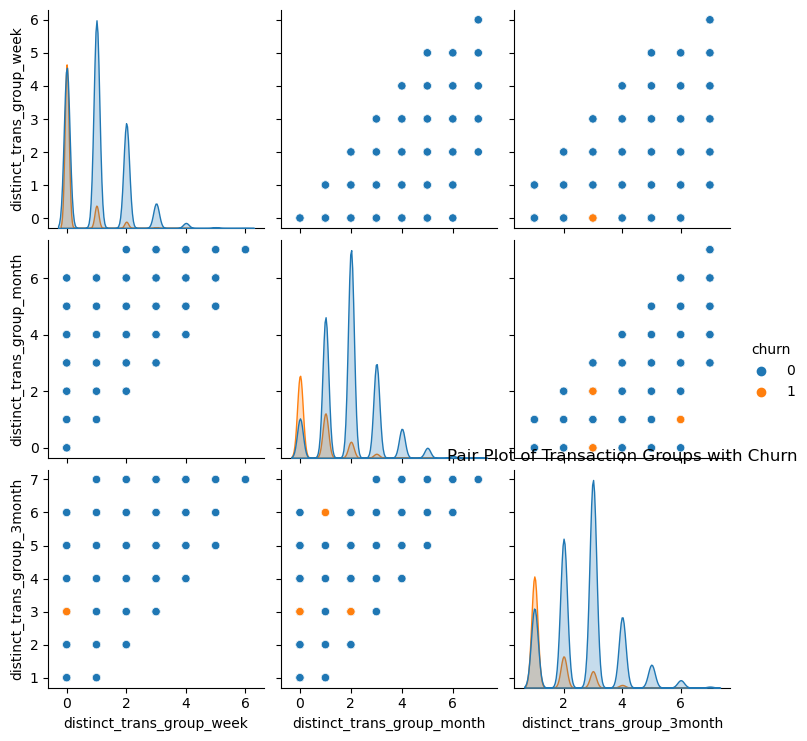

In [ ]:
sns.pairplot(df, vars=['distinct_trans_group_week', 'distinct_trans_group_month', 'distinct_trans_group_3month'], hue='churn')
plt.title('Pair Plot of Transaction Groups with Churn')
plt.show()

Khách hàng có xu hướng churn có thể xuất hiện ở các nhóm giao dịch thấp (0-3) hơn, trong khi các nhóm (4-7) tỷ lệ churn khá thấp.

Sự phân tán giữa các biến cho thấy có một số mối quan hệ đồng biến (positive correlation) giữa các cột. Điều này có thể được giải thích bởi vì khách hàng có xu hướng sử dụng các nhóm giao dịch tương tự nhau trong các khoảng thời gian.

Các biến này có thể cung cấp thông tin giá trị cho mô hình dự đoán churn. Tuy nhiên, nhóm kiểm tra thêm sự tương quan để đảm bảo rằng không có biến nào quá tương quan (multicollinearity).

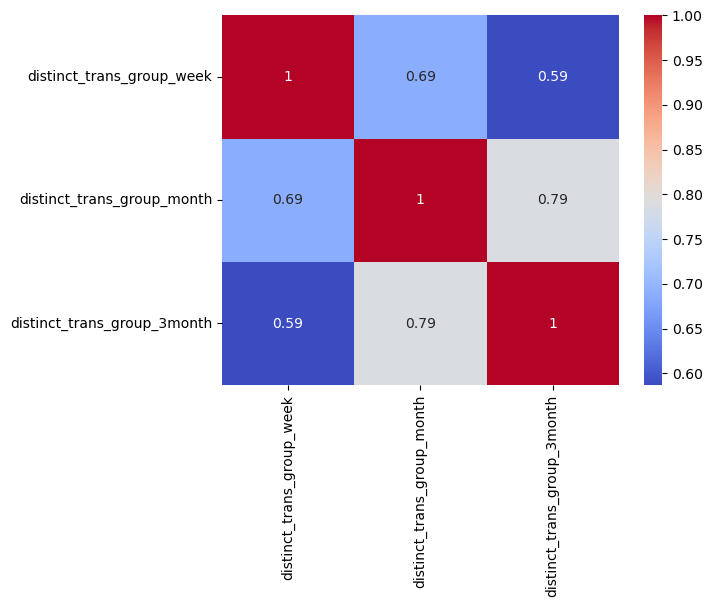

In [24]:
# Tạo ma trận tương quan
corr_matrix = df[['distinct_trans_group_week', 'distinct_trans_group_month', 'distinct_trans_group_3month']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Từ ma trận tương quan dạng heatmap, nhóm thấy rằng cột 'distinct_trans_group_month' có độ tương quan khá cao với 2 cột 1 tuần và 3 tháng trước đó. Do đó, nhóm đề xuất loại bỏ cột 'distinct_trans_group_month' để tránh hiện tượng đa cộng tuyến.

In [26]:
df.drop(columns=['distinct_trans_group_month'], inplace=True)

### 3.7. Check_trans_amount (Trạng thái thực hiện giao dịch tiền)

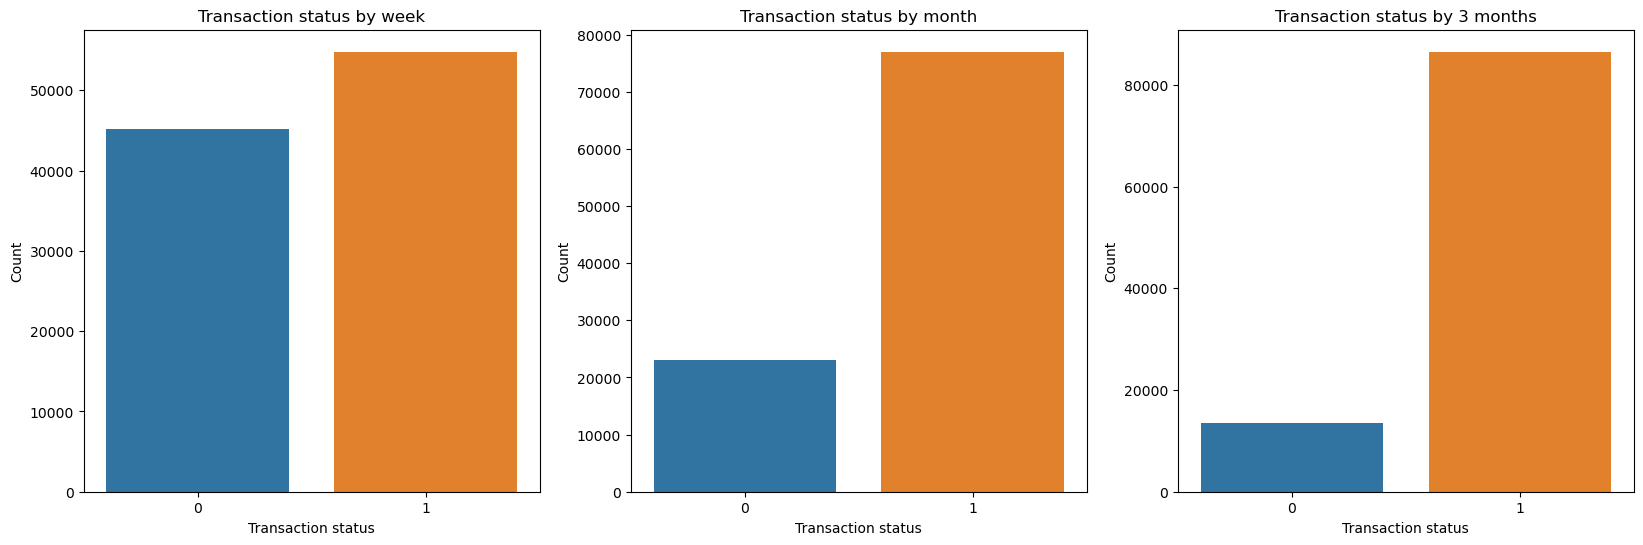

In [27]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
sns.countplot(x='check_trans_amount_week', data=df)
plt.title('Transaction status by week')
plt.xlabel('Transaction status')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.countplot(data=df, x='check_trans_amount_month')
plt.title('Transaction status by month')
plt.xlabel('Transaction status')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.countplot(data=df, x='check_trans_amount_3month')
plt.title('Transaction status by 3 months')
plt.xlabel('Transaction status')
plt.ylabel('Count')

plt.show()

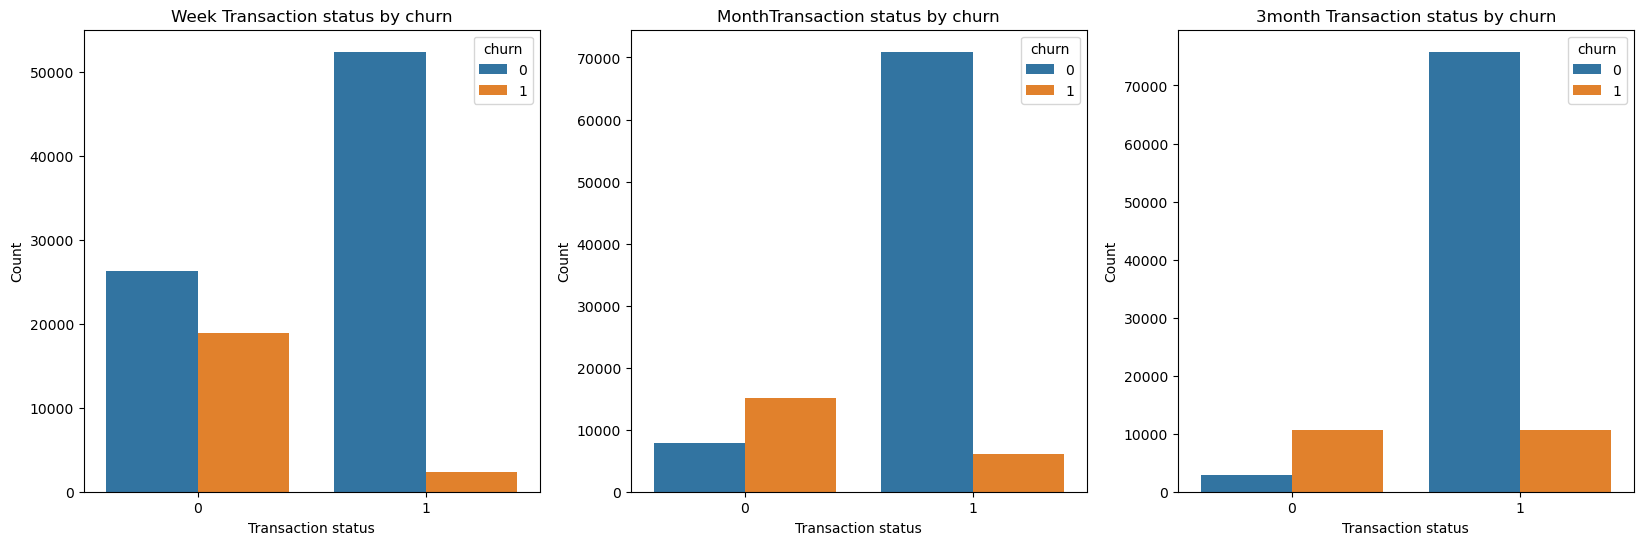

In [28]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
sns.countplot(x='check_trans_amount_week', hue='churn', data=df)
plt.title('Week Transaction status by churn')
plt.xlabel('Transaction status')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.countplot(x='check_trans_amount_month', hue='churn', data=df)
plt.title('MonthTransaction status by churn')
plt.xlabel('Transaction status')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.countplot(x='check_trans_amount_3month', hue='churn', data=df)
plt.title('3month Transaction status by churn')
plt.xlabel('Transaction status')
plt.ylabel('Count')

plt.show()

### Nhận xét:
* Nhiều records có trạng thái thực hiện giao dịch hơn số bản ghi không thực hiện giao dịch
* Qua 3 thời điểm quan sát "week", "month" và "3month" thì số lượng khách hàng không rời bỏ cao hơn ở các quan sát có trạng thái thực hiện giao dịch, trong khi đó, khách hàng rời bỏ (churn) sẽ nhiều hơn với các quan sát không thấy trạng thái thực hiện giao dịch.
* Điều này cũng cho thấy, nếu khách hàng có tần suất thực hiện giao dịch nhiều sẽ có xu hướng ít rời bỏ hơn với khách hàng không sử dụng giao dịch.

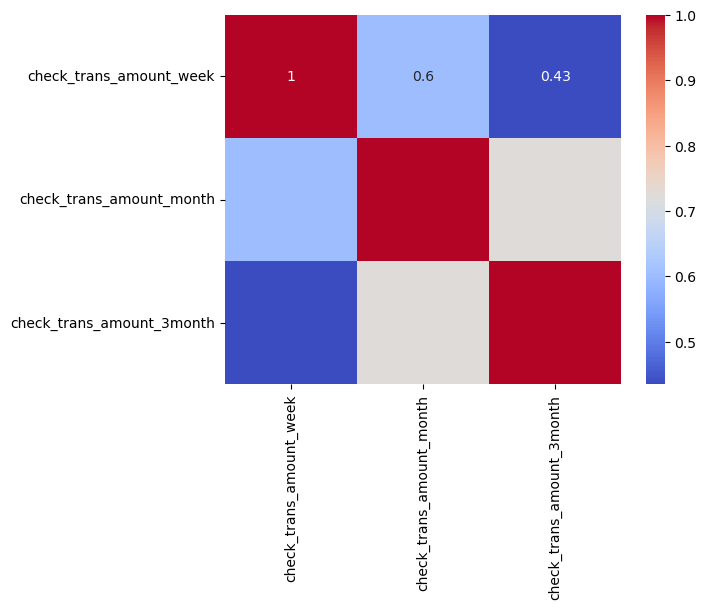

In [55]:
# Tạo ma trận tương quan
corr_matrix = df[['check_trans_amount_week', 'check_trans_amount_month', 'check_trans_amount_3month']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Nhận xét:
1. Cột "check_trans_amount_month" có correlation khá cao so với 2 cột còn lại
2. Nhóm đề xuất loại bỏ cột "check_trans_amount_month" để tránh đa cộng tuyến

In [29]:
df.drop(columns=['check_trans_amount_month'], inplace=True)

# 3.8. Chuẩn hóa kiểu dữ liệu và cột

In [30]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [31]:
df.columns

Index(['gender', 'marital_status', 'distinct_payment_code_week',
       'distinct_trans_group_week', 'distinct_payment_code_3month',
       'count_payment_code_3month', 'distinct_trans_group_3month', 'age',
       'check_trans_amount_week', 'check_trans_amount_3month', 'churn'],
      dtype='object')

In [32]:
# Sử dụng phương pháp One-Hot Encoding cho 2 cột phân loại 'gender', 'marital_status'
df = pd.get_dummies(df, columns=['gender', 'marital_status'], drop_first=True)

In [33]:
df.head()

,distinct_payment_code_week,distinct_trans_group_week,distinct_payment_code_3month,count_payment_code_3month,distinct_trans_group_3month,age,check_trans_amount_week,check_trans_amount_3month,churn,gender_Male,marital_status_Single
0,1,1,1,0.0,2,32,0,1,0,1,0
1,0,0,1,0.0,2,38,0,1,0,1,1
2,0,0,3,3.0,2,44,0,1,0,1,0
3,0,0,1,0.0,1,23,0,0,1,1,1
4,1,1,2,11.0,3,35,1,1,0,1,0


In [34]:
df2 = df

In [35]:
df.columns

Index(['distinct_payment_code_week', 'distinct_trans_group_week',
       'distinct_payment_code_3month', 'count_payment_code_3month',
       'distinct_trans_group_3month', 'age', 'check_trans_amount_week',
       'check_trans_amount_3month', 'churn', 'gender_Male',
       'marital_status_Single'],
      dtype='object')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   distinct_payment_code_week    100000 non-null  int64  
 1   distinct_trans_group_week     100000 non-null  int64  
 2   distinct_payment_code_3month  100000 non-null  int64  
 3   count_payment_code_3month     100000 non-null  float64
 4   distinct_trans_group_3month   100000 non-null  int64  
 5   age                           100000 non-null  int64  
 6   check_trans_amount_week       100000 non-null  int64  
 7   check_trans_amount_3month     100000 non-null  int64  
 8   churn                         100000 non-null  int64  
 9   gender_Male                   100000 non-null  uint8  
 10  marital_status_Single         100000 non-null  uint8  
dtypes: float64(1), int64(8), uint8(2)
memory usage: 7.1 MB


# 4.   Model Development

### 4.1. Chia tệp dữ liệu thành các tập train, test

In [37]:
X = df.drop(columns=['churn'])
y = df['churn']

In [38]:
# Chia dữ liệu thành tập train và tập tạm thời
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Chia tập tạm thời thành tập validation và tập test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [39]:
# Khởi tạo StandardScaler
scaler = StandardScaler()

# Chuẩn hóa cột 'age' trong tập train
X_train['age'] = scaler.fit_transform(X_train[['age']])

# Áp dụng scaler cho tập validation và tập test
X_val['age'] = scaler.transform(X_val[['age']])
X_test['age'] = scaler.transform(X_test[['age']])

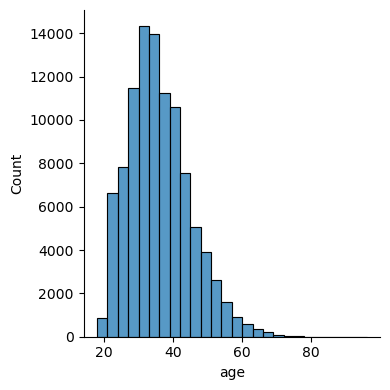

In [40]:
sns.displot(df, x="age", binwidth=3, height=4, aspect=1)

In [41]:
# Kiểm tra kích thước các tập dữ liệu
print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Train set: (70000, 10), Validation set: (15000, 10), Test set: (15000, 10)


### 4.2. Khai báo các mô hình vào lưới siêu tham số

In [42]:
# L1 Regularization (Lasso) - Logistic Regression
logistic_l1 = LogisticRegression(solver='saga', penalty='l1', max_iter=10000)
param_grid_logistic_l1 = {
    'C': [0.1, 1, 10]  # Regularization strength
}

# L2 Regularization (Ridge) - Logistic Regression
logistic_l2 = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=10000)
param_grid_logistic_l2 = {
    'C': [0.1, 1, 10]  # Regularization strength
}

In [43]:
# Decision Tree
decision_tree = DecisionTreeClassifier(random_state=42)
param_grid_decision_tree = {
    'max_depth': [10, 20],
    'min_samples_split': [2, 10],  
    'min_samples_leaf': [1, 5]  
}


In [44]:
# Random Forest
random_forest = RandomForestClassifier(random_state=42)
param_grid_random_forest = {
    'n_estimators': [50, 100],  
    'max_depth': [10, 20],  
    'min_samples_split': [2, 10],  
    'min_samples_leaf': [1, 5]  
}


In [45]:
# Tổng hợp các mô hình và lưới siêu tham số
models = [
    (logistic_l1, param_grid_logistic_l1),
    (logistic_l2, param_grid_logistic_l2),
    (decision_tree, param_grid_decision_tree),
    (random_forest, param_grid_random_forest)
]


### 4.3. Thực hiện tuning trên từng model bằng vòng lặp for

In [46]:
# Khai báo các danh sách để lưu trữ mô hình tốt nhất và điểm số trên tập validation
best_models = []
val_scores = []

In [47]:
#Thực hiện hyperparams tuning 
# Nhóm lựa chọn F1 Score vì đây là chỉ số duy nhất, dễ hiểu, giúp đánh giá hiệu suất mô hình một cách công bằng hơn so với chỉ sử dụng Accuracy, đặc biệt là khi dữ liệu của 2 lớp Churn/ non churn mất cân bằng

for model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, cv=2)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    val_score = f1_score(y_val, best_model.predict(X_val))
    best_models.append(best_model)
    val_scores.append(val_score)

# Lựa chọn best model dựa trên tập validation
best_model_index = np.argmax(val_scores)
best_model = best_models[best_model_index]
print(f"Best Model: {best_model}")
print(f"Validation Set Score: {val_scores[best_model_index]}")

# Combine tập train + validation để retrain lại cho mô hình tốt hơn nữa
X_combined = np.vstack((X_train, X_val))
y_combined = np.hstack((y_train, y_val))
best_model.fit(X_combined, y_combined)

# Đánh giá final model trên tập test 
test_score = f1_score(y_test, best_model.predict(X_test))
print("Test Set Score: ", test_score)

Best Model: RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)
Validation Set Score: 0.6263265686091974
Test Set Score:  0.6322075013995148


In [48]:
best_model

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

### 4.4. Thực hiện đánh giá mô hình đã chọn 

In [49]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92     11811
           1       0.78      0.53      0.63      3189

    accuracy                           0.87     15000
   macro avg       0.83      0.75      0.78     15000
weighted avg       0.86      0.87      0.86     15000



In [50]:
confusion_matrix(y_test, best_model.predict(X_test))

array([[11335,   476],
       [ 1495,  1694]])

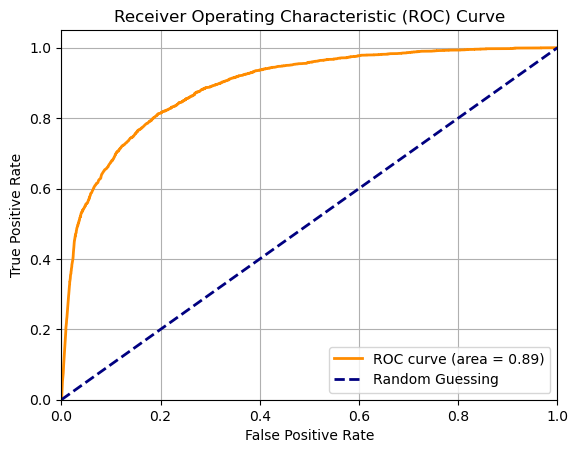

In [51]:
# Dự đoán xác suất hoặc nhãn của tập test
y_score = best_model.predict_proba(X_test)[:, 1] 

# Tính toán ROC curve và AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Vẽ ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 4.5. Nhận xét mô hình RandomForestClassifier

#### Class 0 (Non-churn)
Precision: 0.88, nghĩa là 88% các mẫu được dự đoán là non-churn (0) thực sự là non-churn.

Recall: 0.96. Điều này có nghĩa là 96% các mẫu thực tế là non-churn đã được mô hình dự đoán chính xác.

F1-score: 0.92. F1-score là sự kết hợp hài hòa của Precision và Recall, và với class 0 là 0.92, điều này chỉ ra rằng mô hình hoạt động rất tốt trong việc dự đoán non-churn.

Support: 11811. Đây là số lượng mẫu thực tế của lớp non-churn trong tập test.

#### Class 1 (Churn)
Precision: 0.78. Điều này có nghĩa là 78% các mẫu được dự đoán là churn (1) thực sự là churn.

Recall: 0.53. Điều này có nghĩa là chỉ có 53% các mẫu thực tế là churn đã được mô hình dự đoán chính xác. Đây là chỉ số khá thấp và cho thấy mô hình gặp khó khăn trong việc phát hiện các mẫu churn.

F1-score: 0.63. F1-score với class 1 là 0.63, điều này chỉ ra rằng mô hình cần cải thiện trong việc dự đoán churn.

Support: 3189. Đây là số lượng mẫu thực tế của lớp churn trong tập test.

#### Overall Metrics
Accuracy: 0.87. Đây là tỉ lệ phần trăm các mẫu được dự đoán đúng trên tổng số mẫu. Với 87%, mô hình có độ chính xác tương đối cao.

Macro avg (F1-score): 0.78. Đây là trung bình cộng của các F1-score cho cả hai lớp, không quan tâm đến số lượng mẫu trong mỗi lớp.

Weighted avg (F1-score): 0.86. Đây là trung bình cộng của các F1-score cho cả hai lớp, có quan tâm đến số lượng mẫu trong mỗi lớp. Với 0.86, điều này cho thấy mô hình có hiệu suất tốt tổng thể.

#### Nhận xét
Mô hình Random Forest hoạt động tốt trong việc dự đoán non-churn (0) với các chỉ số Precision, Recall và F1-score cao.

Tuy nhiên, mô hình gặp khó khăn trong việc dự đoán churn (1), với Recall thấp (0.53) và F1-score trung bình (0.63).

#### Do đó, nhóm tiếp tục thực hiện oversampling bằng SMOTE với mô hình XGBoost.

### 4.6. Thực hiện oversampling với mô hình XGBoost

In [43]:
# Sử dụng SMOTE để oversample tập train
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Khởi tạo mô hình XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Thiết lập các siêu tham số cho Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Tối ưu hóa siêu tham số với Grid Search
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_res, y_train_res)

# Lấy mô hình tốt nhất
best_xgb_model = grid_search.best_estimator_
print(f"Best Model: {best_xgb_model}")

# Đánh giá mô hình trên tập validation
y_val_pred = best_xgb_model.predict(X_val)
val_f1_score = f1_score(y_val, y_val_pred)

print(f"Validation F1 Score: {val_f1_score}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Đánh giá mô hình trên tập test
y_test_pred = best_xgb_model.predict(X_test)
test_f1_score = f1_score(y_test, y_test_pred)

print(f"Test F1 Score: {test_f1_score}")
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)
Validation F1 Score: 0.654936974789916
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88

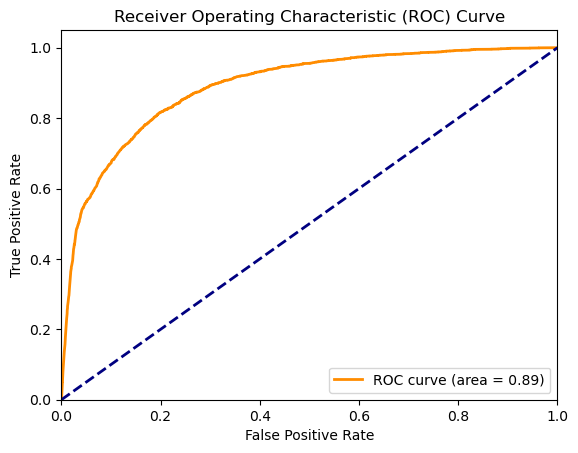

In [49]:
# Vẽ ROC curve
y_test_prob = best_xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Nhận xét mô hình XGBoost
Các chỉ số hiệu suất, đặc biệt là F1 score cho lớp '1' (churn), chưa được cải thiện đáng kể. Mặc dù đã sử dụng SMOTE để cân bằng dữ liệu, vẫn có thể chưa đủ để cải thiện hiệu suất của mô hình. SMOTE không luôn cải thiện hiệu suất nếu dữ liệu có nhiều nhiễu hoặc có các đặc trưng không thể phân biệt tốt giữa các lớp. 

Ngoài ra, Chất lượng và số lượng dữ liệu cũng ảnh hưởng lớn đến hiệu suất của mô hình. Giải pháp: Thử nghiệm với các kỹ thuật làm sạch dữ liệu, xử lý nhiễu, hoặc thu thập thêm dữ liệu nếu có thể.

# 5. Kết luận

### 5.1. Profile of customers who are likely to churn

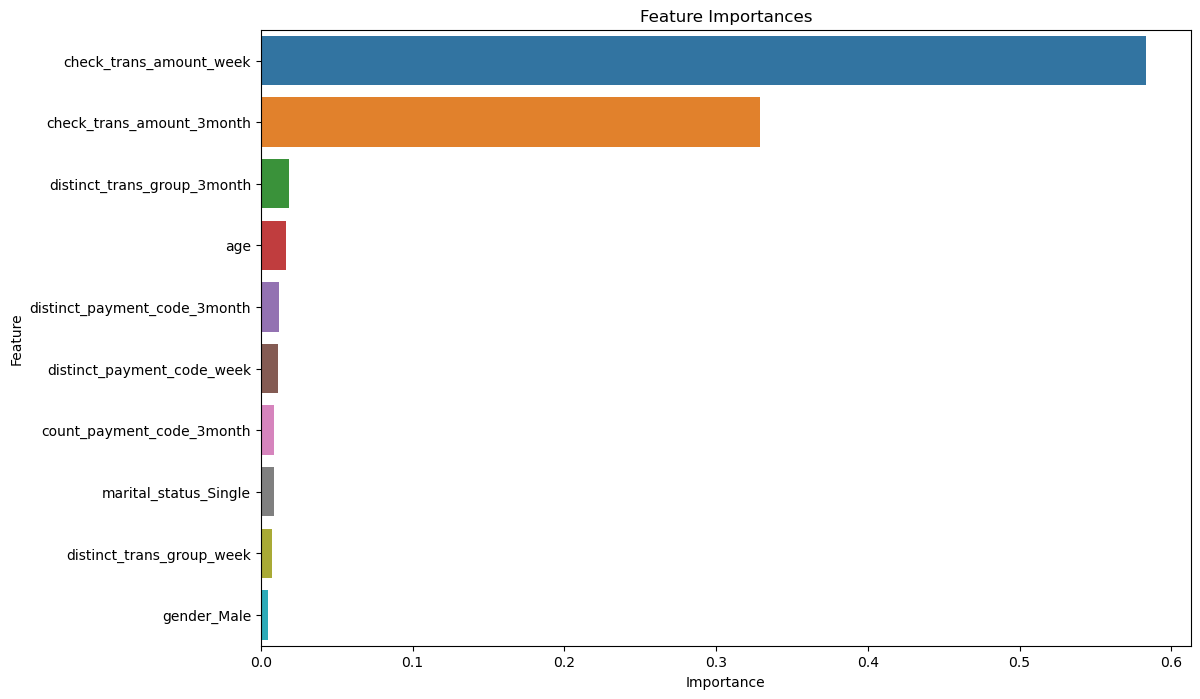

In [51]:
# Trích xuất feature importances từ mô hình tốt nhất
importances = best_xgb_model.feature_importances_
feature_names = X.columns

# Tạo DataFrame cho feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sắp xếp các đặc trưng theo độ quan trọng giảm dần
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Vẽ biểu đồ feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Dựa trên biểu đồ  feature importances, cột quan trọng nhất để dự đoán tỷ lệ khách hàng rời bỏ là "check_trans_amount_week",  "check_trans_amount_3month", biểu thị việc khách hàng có giao dịch 1 tuần hay 3 tháng trước đó hay không. Điều này cho thấy rằng hành vi giao dịch của khách hàng là yếu tố chính để xác định khách hàng có rời bỏ hay không.

Các tính năng quan trọng tiếp theo là "distinct_trans_group_3month" (Nhóm giao dịch khách hàng sử dụng trong 3 tháng trước đó). 

Các tính năng khác, chẳng hạn như độ tuổi, loại dịch vụ khách hàng sử dụng, tình trạng hôn nhân và giới tính, có tầm quan trọng tương đối thấp hơn so với các tính năng liên quan đến giao dịch. Điều này ngụ ý rằng hành vi giao dịch của khách hàng có khả năng dự đoán tỷ lệ khách hàng rời bỏ cao hơn so với các đặc điểm về nhân khẩu học của họ. 

Nhìn chung, biểu đồ tầm quan trọng của tính năng cho thấy rằng mô hình nên tập trung vào hoạt động giao dịch gần đây và trong quá khứ của khách hàng để dự đoán hiệu quả tỷ lệ khách hàng rời bỏ. Hành vi giao dịch hàng tuần và 3 tháng cùng việc sử dụng các nhóm giao dịch dường như là những chỉ số quan trọng nhất cho thấy liệu khách hàng có khả năng rời bỏ hay không.

Doanh nghiệp có thể thực hiện các kế hoạch chăm sóc và nâng cao trải nghiệm giao dịch của khách hàng với các nhóm giao dịch có số liệu được sử dụng nổi bật. Bên cạnh đó, tệp khách hàng chiếm phần lớn được cho là có độ tuổi từ 20-40, là nhóm độ tuổi lao động chất lượng cao. Điều này cũng chỉ ra rằng thấy doanh nghiệp cần chú trọng nâng cao chất lượng sản phẩm và dịch vụ của mình, ví dụ như những dịch vụ và chăm sóc khách hàng trực tuyến (Internet Banking) nhằm mục đích tiết kiệm thời gian, công sức khi khách hàng trải nghiệm các dịch vụ. Cuối cùng là giúp đạt đến mục tiêu trở thành dịch vụ tích hợp nhiều tiện ích và cập nhật nhanh các xu hướng toàn cầu để tăng phần trăm giữ chân được tệp khách hàng này.

### 5.2. Hạn chế và định hướng

#### Hạn chế:
- Bộ dữ liệu có nhiều outliers và missing values, do đó nhóm đặt ra một số giả định để xử lý các dữ liệu này, tuy nhiên giả định có thể chưa phù hợp với bản chất của dữ liệu do mô tả dữ liệu còn nhiều mơ hồ.
- Bộ dữ liệu chứa không nhiều biến và các biến hầu hết có tương quan cao với nhau, nhóm chỉ sử dụng biến có tính đại diện cao nhất nên mô hình có thể ít biến.
- Nhóm vẫn chưa cải thiện được chỉ số đánh giá của mô hình, đặc biệt trong việc xác định đúng khách hàng churn, điều này có thể ảnh hưởng đến việc doanh nghiệp đưa ra những chiến lược giữ chân khách hàng hiệu quả và kịp thời nhất. 

#### Định hướng:
- Tìm hiểu rõ đặc điểm của bộ dữ liệu và chỉ ra nguyên nhân thực tế
- Tìm hiểu thêm về các cách xử lý outliers để mô hình đạt độ chính xác cao hơn 
- Có thể phát triển thêm các trường dữ liệu khác liên quan đến hành vi giao dịch của khách hàng để có nhiều góc nhìn hơn
- Tìm hiểu thêm về các thuật toán khác để phát triển và xử lý, tinh chỉnh mô hình hơn 
- Tìm hiểu thêm các thang đo đánh giá khác để có cái nhìn toàn diện hơn về mô hình
- Tránh can thiệp quá mức vào dữ liệu gây méo mó mô hình, kết quả phản ánh sai lệch thực tế
